## Imports

In [1]:
!pip install pymoo


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# IMPORTS
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras import layers
import random
from tensorflow.keras.models import clone_model
from keras.utils import to_categorical


## Classes

In [3]:
# CLASSES

class Server:
    def __init__(self, devices_list):
        self.model = Server.create_model()
        self.current_learning_iteration = 0
        self.LAST_WEIGHTS_SENT_FOR_ALL_DEVICES = []
        self.x_test_global = []
        self.y_test_global = []
        self.devices = devices_list

    def evaluate(self, x_test=None, y_test=None, verbose = 0):
        if x_test is None and y_test is None:
            test_loss, test_acc = self.model.evaluate(self.x_test_global, self.y_test_global, verbose)
            return test_loss, test_acc
        test_loss, test_acc = self.model.evaluate(x_test, y_test, verbose=verbose)
        return test_loss, test_acc

    def get_weights(self):
        return self.model.get_weights()

    def set_aggregated_weight(self):
        self.model.set_weight(Server.aggregate_weights())

    def give_global_model_weights_to_bitstring_devices(self, bitstring):
        for device in self.devices:
            if int(bitstring[int(device.id)]) == 1:
                device.model.set_weights(self.model.get_weights())

    def create_model():
        model = keras.Sequential([
            layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dense(128, activation='relu'),
            layers.Dense(10, activation='softmax')
        ])
        model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.01),
                        # new
                        loss='categorical_crossentropy', metrics=['accuracy'])
        return model

    def aggregate_weights(self, bitstring):
        """Computes the weighted average of model weights from all devices and updates the global model."""
        def sum_all_nested_lists(list_of_lists):
            def recursive_sum(lists):
                if isinstance(lists[0], list):
                    return [recursive_sum([lst[i] for lst in lists]) for i in range(len(lists[0]))]
                else:
                    return sum(lists)

            return recursive_sum(list_of_lists)

        def multiply_nested_list(lst, factor):
            result = []
            for item in lst:
                if isinstance(item, list):
                    # Recursively handle sublists
                    result.append(multiply_nested_list(item, factor))
                else:
                    # Multiply number
                    result.append(item * factor)
            return result

        selected_devices = []
        for device in self.devices:
            if int(bitstring[int(device.id)]) == 1:
                selected_devices.append(device)

        num_devices = len(selected_devices)
        if num_devices == 0:
            print("No devices available for aggregation.")
            return

        device_participation_ratio = []
        data_lengths = []

        for device in selected_devices:
            # print("*******************")
            # print(device.id)
            device_participation_ratio.append(device.last_round_participated / self.current_learning_iteration)
            # print("this device's participation ratio:")
            # print(device.last_round_participated / self.current_learning_iteration)
            data_lengths.append(len(device.data[0]))
            # print("this device's data to all ratio:")
            # print(len(device.data[0])/60000.0)

        sum_data = 0
        for data_len in data_lengths:
            sum_data += data_len

        data_fractions = []
        for device in selected_devices:
            data_fractions.append(len(device.data[0])/float(sum_data))



        # new
        combined_weights = [fraction * ratio for fraction, ratio in zip(data_fractions, device_participation_ratio)]
        total_weight = sum(combined_weights)
        normalized_weights = [w / total_weight for w in combined_weights]
        print(normalized_weights)


        aggregated_weights_devices = []
        for d in range(len(selected_devices)):
            # aggregated_weights_devices.append(multiply_nested_list(selected_devices[d].model.get_weights(), data_fractions[d]*device_participation_ratio[d]))
            aggregated_weights_devices.append(multiply_nested_list(self.LAST_WEIGHTS_SENT_FOR_ALL_DEVICES[int(selected_devices[d].id)], normalized_weights[d]))

        aggregated_weights = sum_all_nested_lists(aggregated_weights_devices)
        # TODO: Weighted multiplication for each node in each layer of the neural network of the received devices and then summing
        #       the related parts together so that we get a full weighted average of all these devices' models

        print("Aggregated weights:")
        for layer_idx, layer_weights in enumerate(aggregated_weights):
            print(f"Layer {layer_idx}: {layer_weights.shape}")
            
        
        return aggregated_weights


class Device:
    def __init__(self, id, ram, storage, cpu, bandwidth, battery, charging):
        self.id = id
        self.ram = ram
        self.storage = storage
        self.cpu = cpu
        self.bandwidth = bandwidth
        self.battery = battery
        self.charging = charging
        self.model = Server.create_model()
        self.last_round_participated = 0
        self.data = None  # Placeholder for dataset partition
        self.test_data = None
        self.number_of_times_fitted = 0
        
    def lose_battery(self):
        if float(self.battery) > 0.3:
            self.battery -= 0.3
        else:
            self.battery = 0
        


## Functions

In [4]:
# Functions

def fit_bitstring_devices(bitstring, server: Server, epochs=7):
    '''
    server: for using its "current_learning_iteration" variable
    '''

    server.current_learning_iteration += 1
    for device in server.devices:
        if bitstring[int(device.id)] == 1:
            # TODO:
            # makes it so that the random selection might choose a device that's been turned off
            # if the device is off, don't fit, use old weights saved on the server.
            # if the device is on, fit, update the weights saved on the server.
            if device.battery == 0:
                continue
            
            device.lose_battery()
            
            device.model.fit(device.data[0], device.data[1], epochs=epochs, verbose=0)
            print(device.id)
            device.last_round_participated = server.current_learning_iteration
            server.LAST_WEIGHTS_SENT_FOR_ALL_DEVICES[int(device.id)] = device.model.get_weights()
            device.number_of_times_fitted += 1




def niid_labeldir_split(x_data, y_data, num_clients, beta, seed=None):
    num_classes = 10
    y_indices = np.array([np.argmax(label) for label in y_data])  # From one-hot to class index

    rng = np.random.default_rng(seed)  # Local random generator

    # Prepare client partitions
    client_indices = [[] for _ in range(num_clients)]

    for k in range(num_classes):
        idx_k = np.where(y_indices == k)[0]
        rng.shuffle(idx_k)

        # Dirichlet distribution for class k
        proportions = rng.dirichlet(np.repeat(beta, num_clients))

        # Scale proportions to match the number of available samples
        proportions = np.array([int(p * len(idx_k)) for p in proportions])
        # Fix total due to rounding
        while sum(proportions) < len(idx_k):
            proportions[np.argmin(proportions)] += 1
        while sum(proportions) > len(idx_k):
            proportions[np.argmax(proportions)] -= 1

        start = 0
        for i in range(num_clients):
            size = proportions[i]
            client_indices[i].extend(idx_k[start:start + size])
            start += size

    return client_indices



## Load Data

### Load Devices

In [5]:
# Load dataset from CSV
csv_file = 'devices.csv'
df = pd.read_csv(csv_file)
df.columns = df.columns.str.strip().str.lower()

# Convert CSV rows into device objects
devices = []

for _, row in df.iterrows():
    device = Device(
        row['id'], row['ram'], row['storage'], row['cpu'], row['bandwidth'], row['battery'],
        row.get('charging', 0)
    )
    devices.append(device)


# LIMIT TO 30 DEVICES
devices = devices[:30]

d:\Github Repos\FL\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Object Initializations

In [6]:
# Global Model
server = Server(devices_list=devices)
server.LAST_WEIGHTS_SENT_FOR_ALL_DEVICES = [None for _ in range(len(devices))]

### Split Data Among Devices

In [7]:
SEED = 1


# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Convert labels to categorical (one-hot encoded)
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

# Normalize data and reshape for CNN
x_train = x_train.astype("float32") / 255.0
x_train = np.expand_dims(x_train, -1)  # Add channel dimension

x_test = x_test.astype("float32") / 255.0
x_test = np.expand_dims(x_test, -1)  # Add channel dimension


# Lower the amount of data for devices
x_train = x_train[:int(len(x_train)/8)]
y_train = y_train[:int(len(y_train)/8)]




# Correct test split
split_index = int(0.8 * len(x_test))
x_test_devices, y_test_devices = x_test[:split_index], y_test[:split_index]
server.x_test_global, server.y_test_global = x_test[split_index:], y_test[split_index:]

# Training data (for devices)
x_train_devices, y_train_devices = x_train, y_train

# Split training data among devices
beta = 0.5  # lower = more skewed
num_devices = len(devices)
split_indices = niid_labeldir_split(x_train_devices, y_train_devices, num_devices, beta, seed=SEED)

for i, device in enumerate(devices):
    idxs = split_indices[i]
    device.data = (x_train_devices[idxs], y_train_devices[idxs])

# Split test data (device-level)
split_size = len(x_test_devices) // num_devices

for i, device in enumerate(devices):
    start = i * split_size
    end = (i + 1) * split_size if i < num_devices - 1 else len(x_test_devices)
    device.test_data = (x_test_devices[start:end], y_test_devices[start:end])

### Load Other Data

## First Iteration

In [8]:
# First Iteration
bitstring = [1 for _ in range(len(devices))]
print(bitstring)

# Load global model weights
server.model.load_weights("my_model.weights.h5")

# global model sends its weights to all devices
server.give_global_model_weights_to_bitstring_devices(bitstring)

test_loss, test_acc = server.evaluate(verbose=0)
print(f"Global Model Accuracy: {test_acc:.4f}")
print("------------------------------------------------------------")
fit_bitstring_devices(bitstring, server)
server.model.set_weights(server.aggregate_weights(bitstring))
print("------------------------------------------------------------")
test_loss, test_acc = server.evaluate(verbose=0)
print(f"Global Model Accuracy: {test_acc:.4f}")

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0605 - loss: 2.3248 
Global Model Accuracy: 0.0570
------------------------------------------------------------
0.0
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0
28.0
29.0
[0.0408, 0.06426666666666667, 0.0252, 0.020266666666666665, 0.03493333333333333, 0.045066666666666665, 0.0476, 0.0572, 0.014, 0.0424, 0.04346666666666667, 0.028266666666666666, 0.04253333333333333, 0.019333333333333334, 0.03626666666666667, 0.03, 0.021466666666666665, 0.0164, 0.014666666666666666, 0.032933333333333335, 0.0364, 0.027466666666666667, 0.042133333333333335, 0.0112, 0.015733333333333332, 0.019466666666666667, 0.05466666666666667, 0.064, 0.04186666666666667, 0.01]
Aggregated weights:
Layer 0: (3, 3, 1, 32)
Layer 1: (32,)
Layer 2: (5408, 128)
Layer 3: (128,)
Layer 4: (128, 10)
Layer 5: (

In [9]:
!pip install pymoo


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## Random Selection Loop

In [10]:
class Logger:
    def __init__(self):
        self.variances = []

In [11]:
# Parameters
NUM_ROUNDS = 4 # should be 4

In [12]:
import random

def generate_random_binary_list(size):
    return [random.randint(0, 1) for _ in range(size)]

In [13]:

all_runs_fronts = []  # Stores results across runs
all_runs_solutions = []

needed_values_for_comparison = ""

logger = Logger()

for i in range(NUM_ROUNDS):
    # Step 3: Run Optimization
    print("GLOBAL MODEL BEFORE OPTIMIZATION")
    print(server.evaluate())

    bitstring = generate_random_binary_list(len(devices))
    
    
    
    print("Bitstring: ", bitstring)
    print(bitstring.count(1), "devices selected randomly")

    a = server.model.get_weights()
    test_loss, test_acc = server.evaluate()
    print(f"Global Model Accuracy: {test_acc:.4f}")
    print("------------------------------------------------------------")
    print(server.current_learning_iteration, " 1")
    server.give_global_model_weights_to_bitstring_devices(bitstring)
    print(server.current_learning_iteration, " 2")
    fit_bitstring_devices(bitstring, server=server, epochs=7)
    print(server.current_learning_iteration, " 3")
    server.model.set_weights(server.aggregate_weights(bitstring))
    print(server.current_learning_iteration, " 4")
    print("------------------------------------------------------------")
    test_loss, test_acc = server.evaluate()
    print(f"Global Model Accuracy: {test_acc:.4f}")
    
    accuracies = []
    for device in devices:
        loss, acc = server.evaluate(x_test=device.test_data[0], y_test=device.test_data[1], verbose=0)
        accuracies.append(acc)
    
    logger.variances.append([i,i,bitstring,1.0/np.var(accuracies)])
    
    
    
    # ---
    
    accuracies = []

    for device in server.devices:
        x_test = device.test_data[0]
        y_test = device.test_data[1]
        
        loss, accuracy = server.evaluate(x_test, y_test)
        
        accuracies.append(round(accuracy, 2))
        print(f"Device {device.id} Accuracy: {round(accuracy, 2)}")

    VARIANCE = np.var(accuracies)
    VARIANCE_SCORE = 1.0/VARIANCE
    MEAN = np.mean(accuracies)
    STANDARD_DEVIATION = np.std(accuracies)
    FAIRNESS = 1.0/STANDARD_DEVIATION
    
    needed_values_for_comparison += f"Round: {i+1}\nServer Test Accuracy: {test_acc}\nVariance: {VARIANCE}\nVariance Score: {VARIANCE_SCORE}\nMean: {MEAN}\nStandard Deviation: {STANDARD_DEVIATION}\nFairness: {FAIRNESS}\n---\n"

GLOBAL MODEL BEFORE OPTIMIZATION
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7194 - loss: 1.6638
(1.6908509731292725, 0.7095000147819519)
Bitstring:  [0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0]
16 devices selected randomly
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7194 - loss: 1.6638
Global Model Accuracy: 0.7095
------------------------------------------------------------
1  1
1  2
1.0
2.0
5.0
8.0
11.0
12.0
13.0
14.0
19.0
20.0
21.0
26.0
27.0
2  3
[0.121242610992328, 0.04754118978744812, 0.08502075210665325, 0.026411772104137844, 0.05332662558168783, 0.08024147905923783, 0.03647339957238083, 0.06841906678405232, 0.020249025279839013, 0.06213054961640045, 0.0686706074707584, 0.051817381461451394, 0.03974342849955981, 0.014840900515658407, 0.10313168154949062, 0.12073952961891585]
Aggregated weights:
Layer 0: (3, 3, 1, 32)
Layer 1: (32,)
Layer 2: (5408, 128)
Layer 3: (128,)
Layer 4: (128, 10)
Layer 5: (10,)
2  4
---------

In [14]:
import plotly.graph_objects as go
import pandas as pd

# Example data (replace with your own)
data = logger.variances
for item in data:
    print(item)

# Convert to DataFrame for easy grouping
df = pd.DataFrame(data, columns=["round_idx", "gen_idx", "bitstring", "variance"])

# For each round & generation, find the row with minimum variance
df_min = df.loc[df.groupby(["round_idx", "gen_idx"])["variance"].idxmin()]

# Create interactive plot
fig = go.Figure()

for round_val, group in df_min.groupby("round_idx"):
    print(group)
    fig.add_trace(
        go.Scatter(
            x=group["gen_idx"],
            y=group["variance"],
            mode="lines+markers",
            name=f"Round {round_val}",
            text=[f"Bitstring: {b}" for b in group["bitstring"]],
            hovertemplate="Gen: %{x}<br>Variance: %{y}<br>%{text}"
        )
    )

fig.update_layout(
    title="Minimum Variance per Generation for Each Round",
    xaxis_title="Generation Index",
    yaxis_title="Variance",
    hovermode="closest"
)

fig.show()


[0, 0, [0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0], np.float64(410.8506642868443)]
[1, 1, [0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0], np.float64(333.2093142400757)]
[2, 2, [0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1], np.float64(443.15138359030965)]
[3, 3, [0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1], np.float64(387.6447594208045)]
   round_idx  gen_idx                                          bitstring  \
0          0        0  [0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, ...   

     variance  
0  410.850664  
   round_idx  gen_idx                                          bitstring  \
1          1        1  [0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, ...   

     variance  
1  333.209314  
   round_idx  gen_idx                                          bitstring  \
2          2        2  [0, 1, 1, 

In [15]:
accuracies = []

for device in server.devices:
    x_test = device.test_data[0]
    y_test = device.test_data[1]
    
    loss, accuracy = server.evaluate(x_test, y_test)
    
    accuracies.append(round(accuracy, 2))
    print(f"Device {device.id} Accuracy: {round(accuracy, 2)}")

VARIANCE = np.var(accuracies)
VARIANCE_SCORE = 1.0/VARIANCE
MEAN = np.mean(accuracies)
STANDARD_DEVIATION = np.std(accuracies)

Device 0.0 Accuracy: 0.78
Device 1.0 Accuracy: 0.76
Device 2.0 Accuracy: 0.77
Device 3.0 Accuracy: 0.82
Device 4.0 Accuracy: 0.7
Device 5.0 Accuracy: 0.78
Device 6.0 Accuracy: 0.79
Device 7.0 Accuracy: 0.73
Device 8.0 Accuracy: 0.79
Device 9.0 Accuracy: 0.77
Device 10.0 Accuracy: 0.77
Device 11.0 Accuracy: 0.8
Device 12.0 Accuracy: 0.77
Device 13.0 Accuracy: 0.78
Device 14.0 Accuracy: 0.74
Device 15.0 Accuracy: 0.8
Device 16.0 Accuracy: 0.76
Device 17.0 Accuracy: 0.83
Device 18.0 Accuracy: 0.79
Device 19.0 Accuracy: 0.87
Device 20.0 Accuracy: 0.88
Device 21.0 Accuracy: 0.8
Device 22.0 Accuracy: 0.76
Device 23.0 Accuracy: 0.92
Device 24.0 Accuracy: 0.88
Device 25.0 Accuracy: 0.82
Device 26.0 Accuracy: 0.88
Device 27.0 Accuracy: 0.84
Device 28.0 Accuracy: 0.87
Device 29.0 Accuracy: 0.87


In [16]:
print(f"MEAN: {MEAN}")
print(f"VARIANCE: {VARIANCE}")
print(f"STANDARD_DEVIATION: {STANDARD_DEVIATION}")
print(f"Fairness: {1.0/STANDARD_DEVIATION}")

MEAN: 0.804
VARIANCE: 0.0026506666666666666
STANDARD_DEVIATION: 0.05148462553682086
Fairness: 19.423274221637648


In [17]:
print(needed_values_for_comparison)

Round: 1
Server Test Accuracy: 0.765500009059906
Variance: 0.002549000000000001
Variance Score: 392.3107100823851
Mean: 0.7390000000000002
Standard Deviation: 0.05048762224545736
Fairness: 19.8068349334866
---
Round: 2
Server Test Accuracy: 0.8654999732971191
Variance: 0.0030645555555555556
Variance Score: 326.3115913128603
Mean: 0.8023333333333333
Standard Deviation: 0.05535842804447716
Fairness: 18.064096747771817
---
Round: 3
Server Test Accuracy: 0.8889999985694885
Variance: 0.002198222222222221
Variance Score: 454.91306105944216
Mean: 0.8453333333333332
Standard Deviation: 0.046885202593379305
Fairness: 21.328691030146274
---
Round: 4
Server Test Accuracy: 0.8650000095367432
Variance: 0.0026506666666666666
Variance Score: 377.2635814889336
Mean: 0.804
Standard Deviation: 0.05148462553682086
Fairness: 19.423274221637648
---



In [18]:
accuracy_plot_x = []
accuracy_plot_y = []

for item in needed_values_for_comparison.split("---")[:-1]:
    for subitem in item.split("\n"):
        if "Server Test Accuracy" in subitem:
            print(float(subitem[subitem.find(": ")+2:]))
            accuracy_plot_y.append(float(subitem[subitem.find(": ")+2:]))
        
    accuracy_plot_x.append(needed_values_for_comparison.split("---").index(item)+1)
        
print(accuracy_plot_x)
print(accuracy_plot_y)

0.765500009059906
0.8654999732971191
0.8889999985694885
0.8650000095367432
[1, 2, 3, 4]
[0.765500009059906, 0.8654999732971191, 0.8889999985694885, 0.8650000095367432]


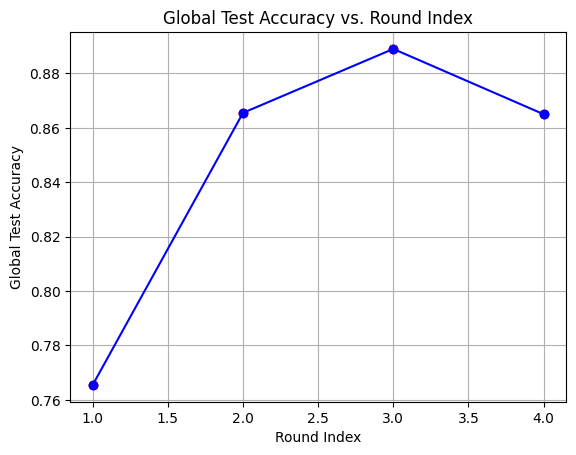

In [19]:
import matplotlib.pyplot as plt

# Example points (replace with your own x and y values)
x = accuracy_plot_x
y = accuracy_plot_y

# Scatter plot of points
plt.scatter(x, y, color='red', zorder=2)

# Plot line with markers
plt.plot(x, y, marker='o', linestyle='-', color='blue')

# Highlight the points explicitly if you like
plt.scatter(x, y, color='red')

plt.xlabel("Round Index")
plt.ylabel("Global Test Accuracy")
plt.title("Global Test Accuracy vs. Round Index")
plt.grid(True)
plt.show()
